# COVID-19 Data Tutorial III
<div style="color: gray">
<i>Samuel S Watson</i> <br>
    <i>Brown University Data Science Initiative</i>
</div>

*This document is a prepared transcript from a tutorial on COVID-19 data on June 19, 2020*

*At the bottom you'll find a section called *Code* with complete code to generate the figures and perform the analysis discussed in the first section*.

## Introduction

Welcome! Thanks for being here. I'm looking forward to presenting what I've prepared for today; I hope it's going to be fun.

The topic this week is sort of the same as last time, so some explanation is warranted how the two presentations are related.

Basically, we were quite short on time last time, due to an issue with the Zoom link (again, my apologies for that!). I decided to overhaul what I was going to present in the second part of that session, so that folks could attend this week without catching up from last time.

I think you'll find the end result is a significantly more straightforward and comprehensible analysis (the material I was going to present last week is available in a Jupyter notebook on the [main page](https://browndsi.github.io/covid19/) for these events).

## Babylon House 

For those who might be new, I'd like to comment on the classroom environment we're using here.

It's called *Babylon House*, and it's a joint project between me and my longtime friend [Luke Davis](http://www.lucaswadedavis.com/). The goal is to make class a high-bandwidth two-way dialogue between students and instructional staff. This is facilitated on the instructor side by doing some natural language analysis on messages submitted by students and organizing them into clusters for batch responding.
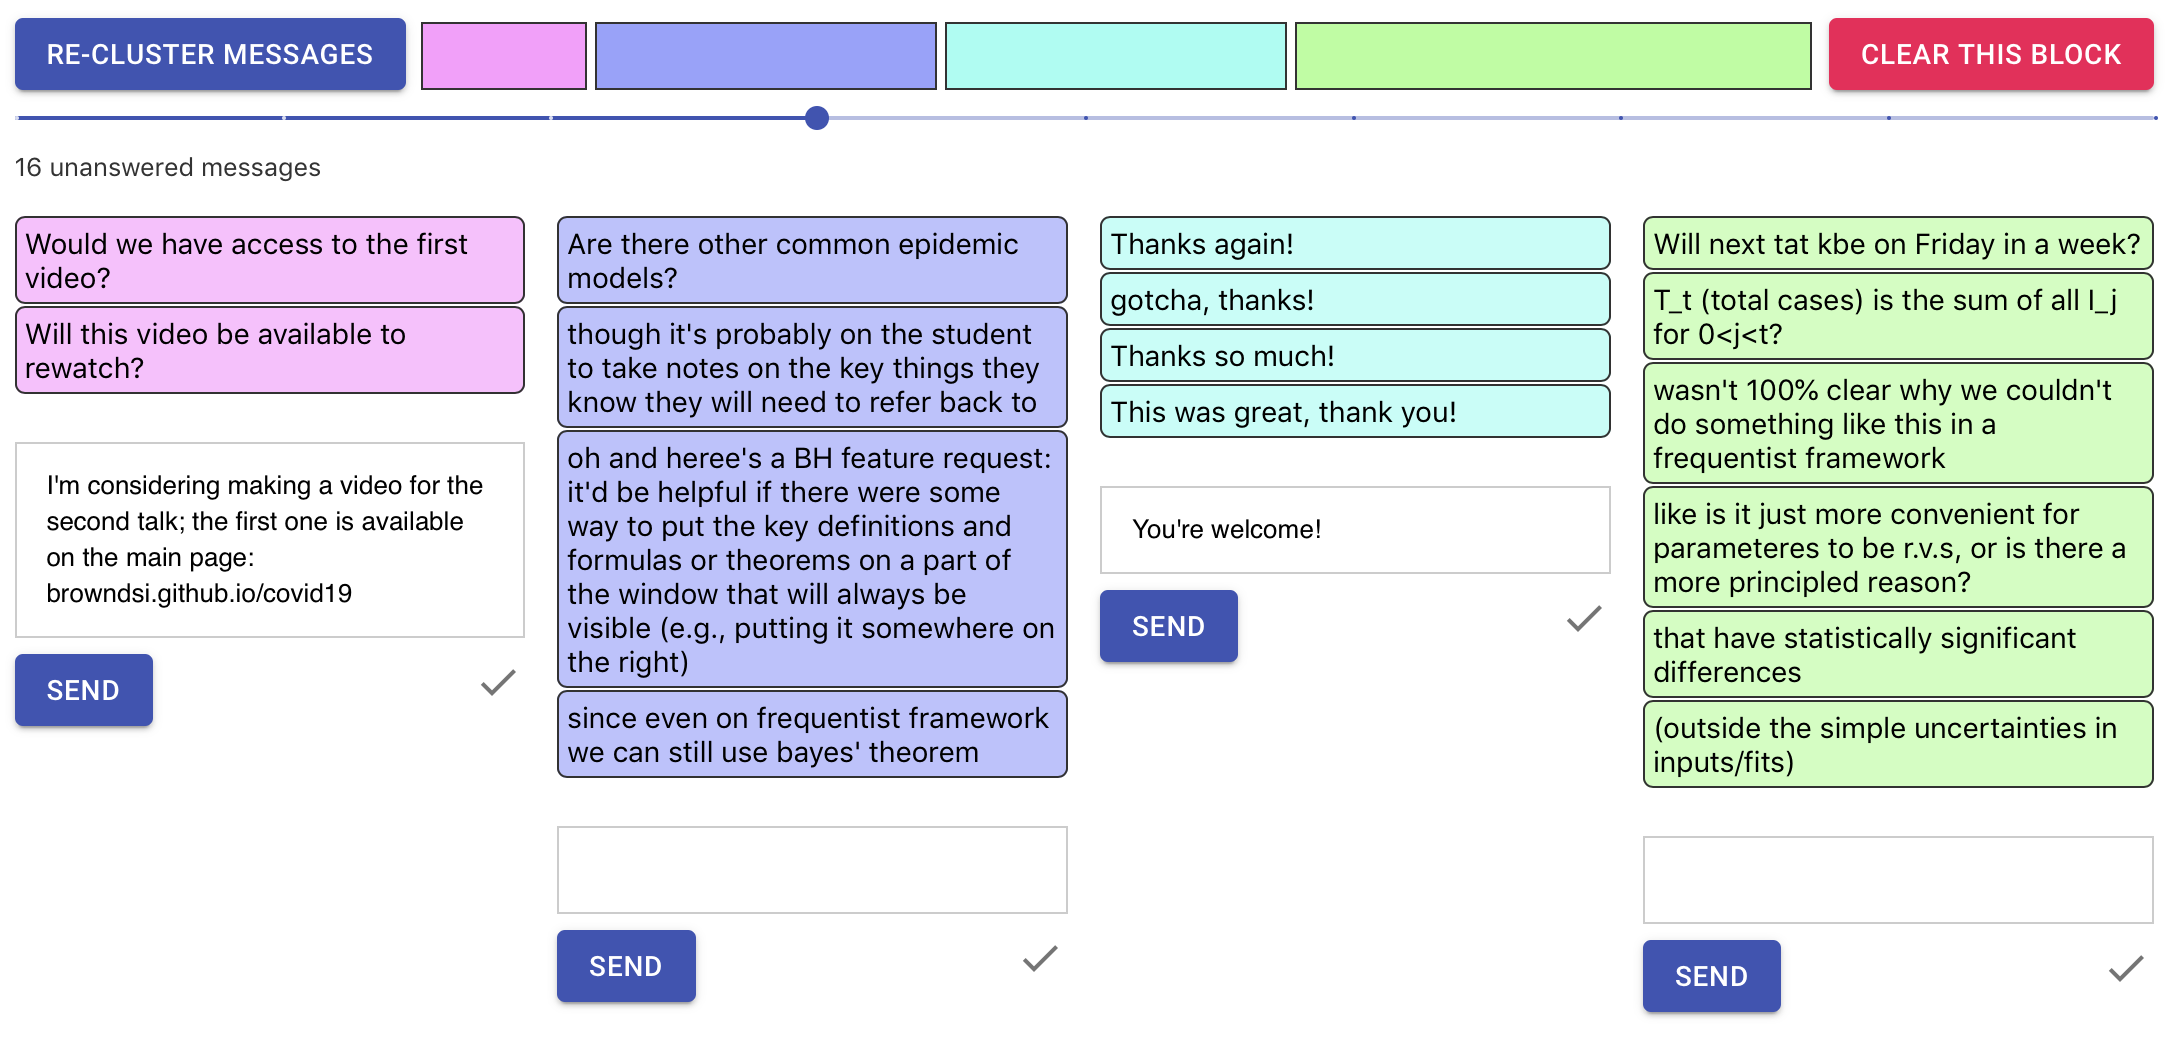

It's free, and you're welcome to use it for your own meetings or classes. I've organized details for setting up a BH-based class at [The Live Classroom](https://theliveclassroom.org/), if you're interested in seeing videos and further explanation.

You're already logged in, so you can just click "Create a new course" in the bottom of the courses pane (or on the landing page, https://babylon.house) to play around with it if you want.

In particular, you don't have to pre-script your lesson as I have done here. You can just use it for apprehending the spectrum of responses submitted by students to questions that you ask via audio on the Zoom side.

Due to the nature of this meeting, we won't be using BH in quite the same way as a class. That is, I'd normally go slower and take more time on questions.

Nevertheless, I'll ask some questions along the way, and I'd love for you to participate in responding. You can also use the platform for surfacing questions you might like to see addressed in class. The messages you send come to me only at first, and I can share messages with the class where appropriate.

## Julia and Pluto

A second comment on the choice of tooling here. Unlike the previous two tutorials, which were aimed at equipping you with common tools (Python, Pandas, and Colab), here we'll look to explore some things that are cool about some totally different systems.

There are ways to achieve a similar analysis with more commonly used tools; for that, you can see the notebook from last time.

But: 
1.  I thought it would be fun to take a look at some fresh stuff, and 
2.  These particular tools do optimize on expositional clarity, IMHO.

So, what are the new things? 

1.  [**Julia**](https://julialang.org/). This language is an alternative to Python, R, or MATLAB. It's free and relatively new, and its major selling point it's as convenient as those languages while being comparable to compiled languages on speed.
2.  [**Pluto**](https://github.com/fonsp/Pluto.jl) notebooks are a lightweight, Julia-specific alternative to Jupyter notebooks. The main advantage over Jupyter notebooks is that the dependency relationships between cells are managed internally by Pluto by analyzing your code, and changes automatically trigger re-calculation of dependent cells. Think of it like Excel but in a notebook.

Unfortunately, Pluto is very new and currently only available to serve locally on your own machine, and I don't want folks to have to set that up now. So I'm going to deviate from the code-along style from the last couple sessions, though I will also make notebooks available (both Jupyter and Pluto), as well as the fairly straightforward download instructions, so you can have a look at the details later if you want.

## Estimating Rₜ

The statistical question we're going to tackle today is the relationship between $R_t$, the average number of infection transmissions induced by each infectious person at time t, and the daily reported case totals.

For concreteness, consider this (simulated) dataset.

It starts around 2, decreasing over time to about 0.75. The daily case count flattens out around the time Rₜ gets to about 1, and then it begins to decrease as Rₜ gets smaller than 1.

This makes sense, because if $R_t > 1$, then more people will be infected in the near-term future, while if $R_t < 1$, then fewer people are getting infected in each new generation of the virus.

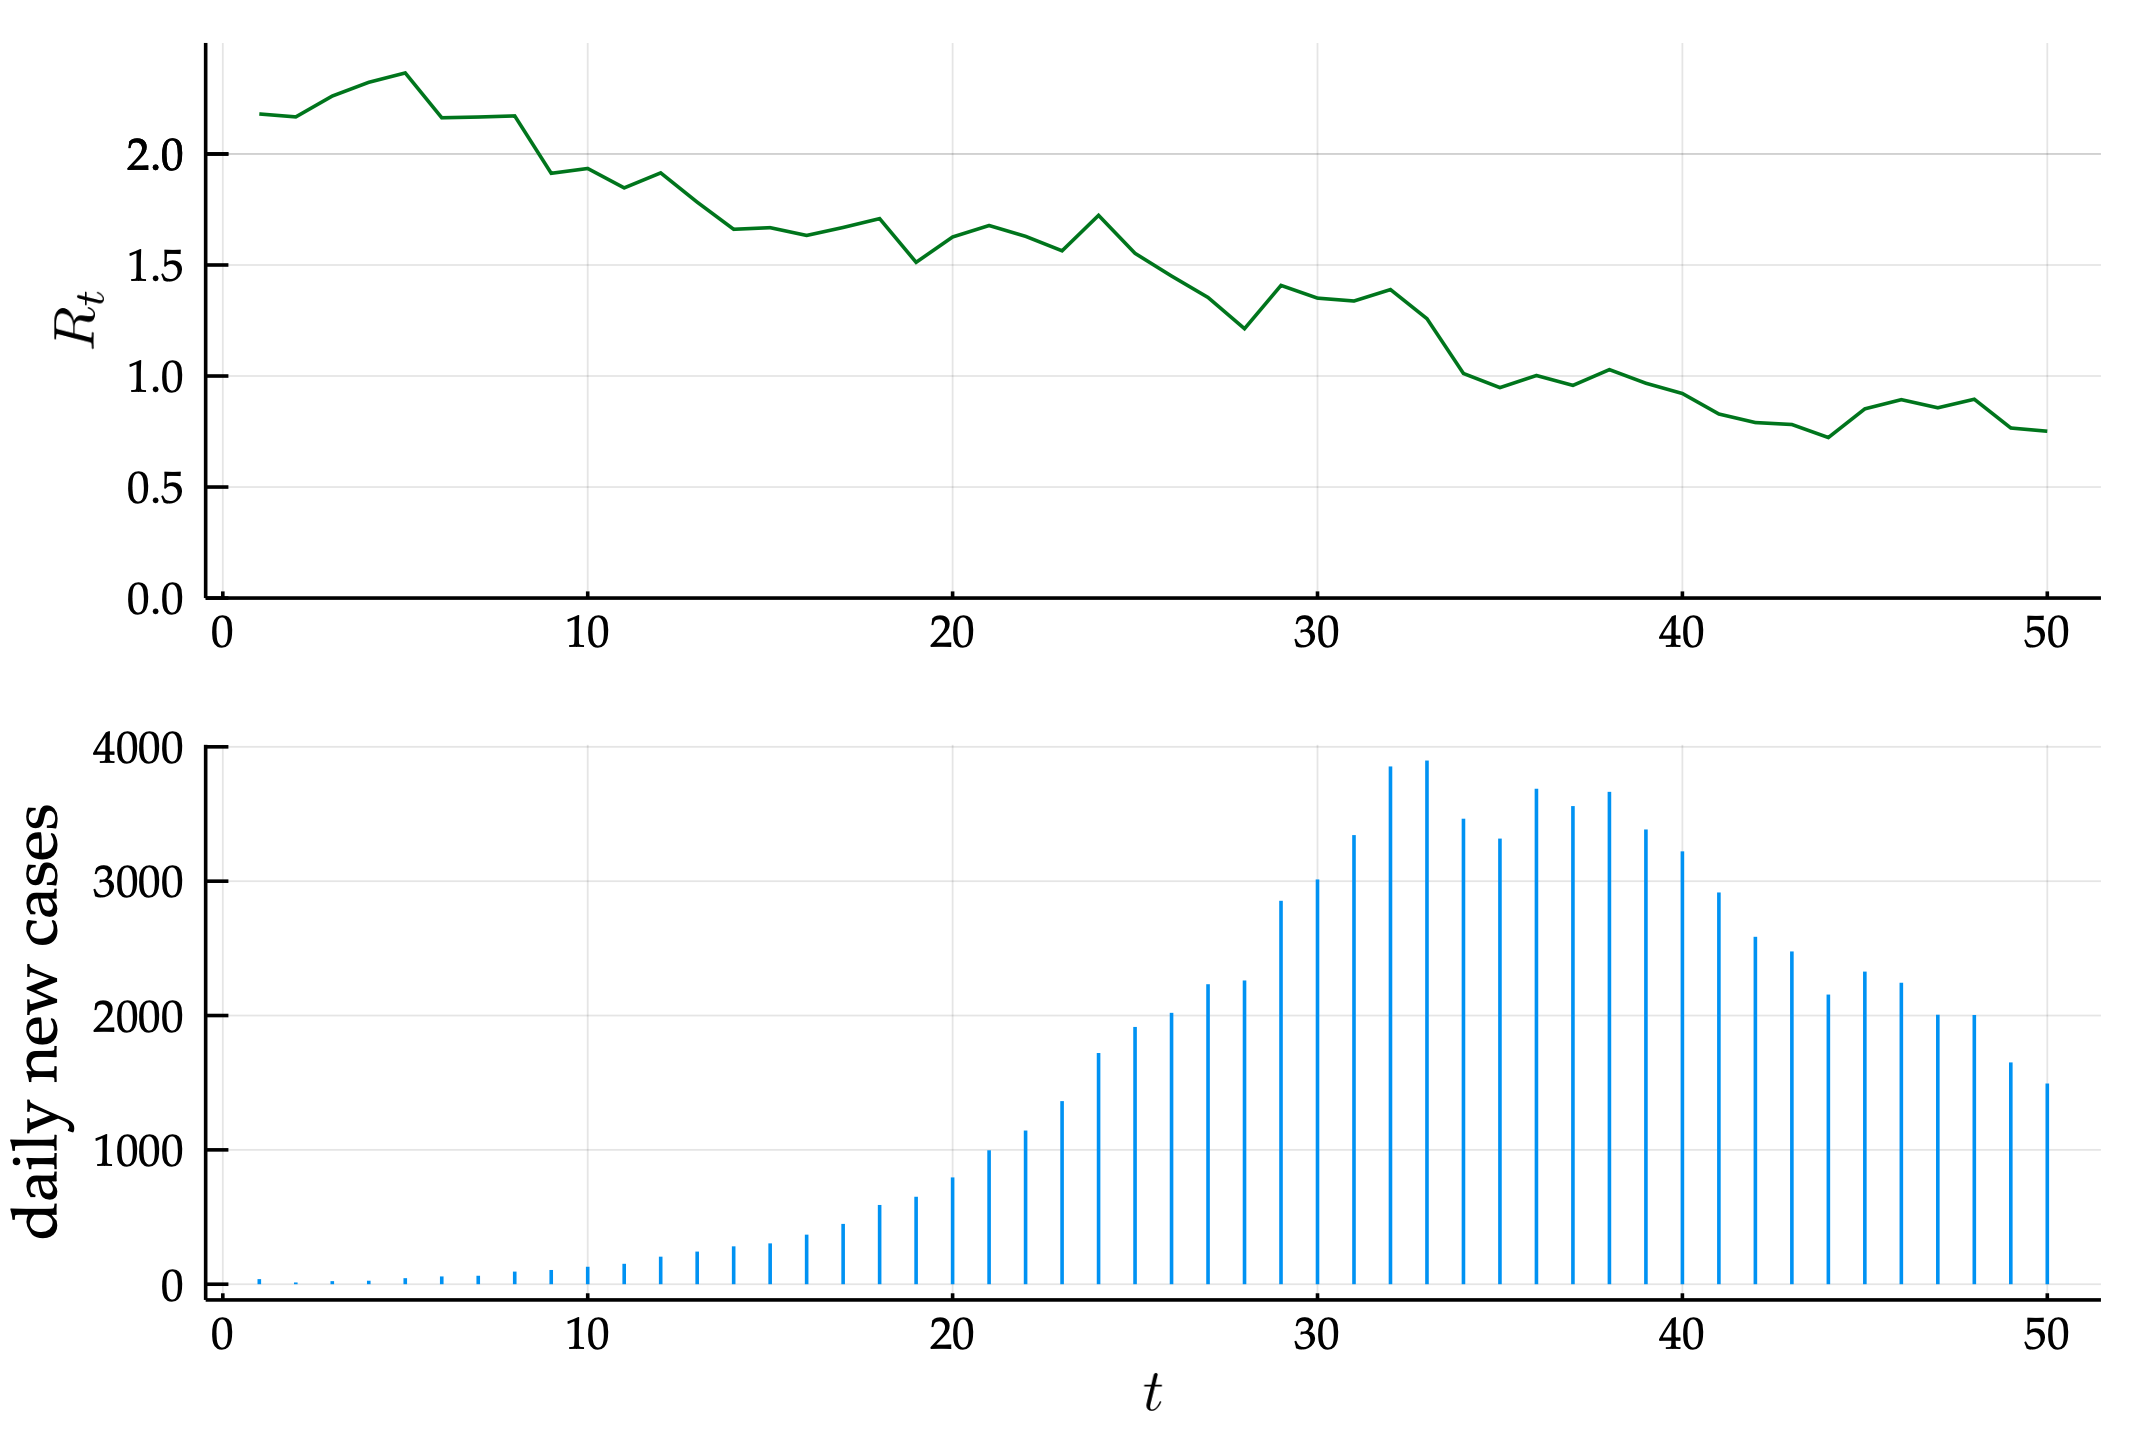

In the real world, of course, we get the second graph but not the first. The first provides a distinct policy insight, though, because you can see how far we are from the exponential growth regime. 

For example, if $R_t \approx 0.5$, then relaxing policies slightly might be more feasible than if $R_t$ were already quite close to $1$.

## A Probabilistic Model 

So let's think about how we would probabilistically simulate the bottom figure (case counts) given the top figure ($R_t$). Once we have a model to take us in that direction, we will use some very impressive and general techniques for going back the other way, inferring the top figure from the bottom. 

We'll make a couple simplifying assumptions:

1.  Every infectious person is reported at the time they become infectious. 
2.  Each person is infectious for a specific number of days, which we'll call P.

While these are substantial oversimplifications and deserve to be addressed, we'll see that the framework we develop here is actually general enough to accommodate that just by adding complexity to the forward model.

So let's stick with this simple setup for now.

### A small math problem 

Now, suppose you know the values of $R_t$ for all times $t$, and you know the case counts for the past P days. What's going to happen tomorrow?

For concreteness, suppose we have $P = 5$, that the case counts over the past 5 days were $[121, 117, 136, 130, 144]$, and that $R_{\text{now}} = 1.5$. 

What should we be doing with those five numbers to figure out how many folks are going to be infected tomorrow? (This is a BH question; I invite you to respond!)

...

An infectious person infects $R_t/P$ persons on average each day, so if we add the number of infectious people over the past five days and multiply by $R_t/P$, that gives us the average number of people infected tomorrow.

However, this is just an *average*. The actual number is going to be random, because what's going on is that each person in the larger susceptible population is effectively being exposed to a small risk of transmission each day (this risk being a function of R_t and the number of infectious individuals). 

Is there a named probability distribution which represents the number of low-probability successes in a large number of independent trials? (Again, you're welcome to respond!)

Right, the *Poisson* distribution describes the number of successes in a large number of low-probability trails (in addition to the obvious resources like Wikipedia, the Poisson distribution is developed [here](https://mathigon.org/course/intro-probability/common-distributions) in Data Gymnasia).

One nice thing about the Poisson distribution is that it's characterized by its mean, which we already have!

## Probabilistic Programming

Rather than using math notation, let's write this out in pseudocode. 

If `n` is the number of days, then we'd say:

```
for i in 2:n
    cases[i] ~ Poisson(Rₜ[i] / P * sum(cases[i-P:i-1])))
end
```

The tilde is common notation for "is distributed as".

The rest is just saying what we already said: the number of case counts on each day is Poisson distributed with mean given by the product of the value stored in the `Rₜ` array for today, the reciprocal of `P`, and the sum of the number of cases over the previous P days.

Here's the part where I can try to impress you: that pseudocode runs in Julia! Furthermore, this kind of code is all we're going to need to write. We don't have to do any clever math like the stuff we started developing last time.

We'll just say "here's how I think these data were generated and here's the observed data, tell me what's going on with the observed variables".

Systems that do that are called **probabilistic programming** systems, and we're going to use one called Turing in Julia. There's a [section on probabilistic programming](https://mathigon.org/course/bayesian-inference-and-graphical-models/probabilistic-programming) on Data Gymnasia (which uses Turing).

Part of the required inputs for the problem is a **prior** distribution for the unobserved variables (in this case, the $R_t$ values). Essentially, we need to say what we would have thought about how those variables are distributed before we see the data.

Often folks approach this by trying to be as agnostic as possible, giving "flat" priors which don't build in a strong bias about which values those variables might or might not take on.

### A prior for Rₜ

In this case, we need to specify a prior for the full $R_t$ curve. We could use a uniform distribution for each day, but that really assumes too little. If we know $R_{\text{yesterday}}$, then $R_{\text{today}}$ is very unlikely to be hugely different.

So basically we'll want to assume that today's $R_t$ value is generated as yesterday's plus a small step up or down. This makes the whole curve $R_t$ a *random walk*. 

Let's put it all together in code. We're going to add the simplifying assumption that $P = 5$, although we could also specify a prior distribution for $P$. 

```
@model SIR(Rₜ, cases) = begin
    n = length(Rₜ)
    P = 5
    Rₜ[1] ~ Uniform(0.5, 3)
    for i in 2:n
        Rₜ[i] ~ truncated(Normal(Rₜ[i-1], 0.1), 0, Inf)
    end
    cases[1] ~ DiscreteUniform(10, 100)
    for i in 2:n
        cases[i] ~ Poisson(Rₜ[i] / P * sum(cases[max(1, i-P):i-1]))
    end
    Rₜ, cases
end
```

Note that we had to truncate the normal distribution, because we want to prevent $R_t$ from going negative.

We could use this model to for simulation by supplying `missing` for both variables and calling the resulting model:

```
Rₜ, cases = SIR(missing, missing)()
```

That's how the plot we've been looking at above was generated. 

Remarkably, we can solve this apparently very complex inverse problem by just handing it to Turing (!!). We supply the observed values and call Turing's `sample` function. We also supply a sampler, in this case NUTS (*No U-Turn Sampler*). Turing provides a handful of samplers, and you can read about them [here].

Choosing an appropriate sampler, as well as other parameters of the sampling process, is the no-free-lunch aspect of probabilistic programming systems. It's possible to make bad choices and get garbage results, so applying this kind of analysis to really complex systems can require some experience to do well.

### Sampling Rₜ from its conditional distribution

However, in this case it works beautifully: we just supply our observed `cases`array rather than `missing`, and Turing does the rest:

```
sample(SIR(missing, cases), NUTS(), 500)
```

The way a sampler represents the distribution of the unobserved data given the observed data is by drawing many observations from that distribution (this is the last argument supplied to `sample` above).

While this seems inferior to having a more direct description of the conditional distribution (a density, for example), in some ways it's better. 

For example, we can get a pretty good sense of the conditional distribution of Rₜ by plotting the 500 runs obtained in the sampling process above:

Looking back at the original $R_t$ plot, we can see that when the assumptions of the model are satisfied (as they are here because we simulated the data!), the results of the sampling process are highly informative.

Not only do they give us a pretty good sense of the values of the unobserved variables, they also give us information about the *variance* of the conditional distribution given the observed variables.

### A peek under the hood

The way the sampler works is by starting at some set of values for the unobserved variables and then sort of feeling its way through the probabilistic landscape. It considers a small nudge to the current values and ascertains whether that step takes it in a direction of higher or lower probability density.

This is kind of like gradient ascent in numerical optimization, except that the sampler doesn't always look to step in a direction of probability density increase. It tends to move quickly away from regions of low density, but it moves all around in regions with a decent amount of density. Here's an example (from the DATA 1010 [cheatsheet](https://data1010.github.io/docs/cheatsheets/data1010-cheatsheet.pdf)) showing a sampler drawing from a distribution on the plane (with density f):

To be clear, the sampler does all that walking and then only returns a single value (where it is at the end of the process). It has to do the walking all over again to return a second sample. 

As a result, Bayesian analysis is typically very computationally intensive.

## Using real COVID-19 data 

Like last time, we're going to get out data from the COVID-19 Tracking Project. Here's what that looks like in code:

```
using DataFrames, UrlDownload
url = "https://covidtracking.com/api/v1/states/daily.csv"
df = DataFrame(urldownload(url))
```

Here's where I'm going to showcase what's cool about Pluto. You can bind Julia values to HTML elements, so that changes you make to a slider or text field propagate as appropriate to other images and text content on the page.

We can apply the `sample` function with these case count curves and see what we get. I did the calculation for my home state of Mississippi, and here's what I got:

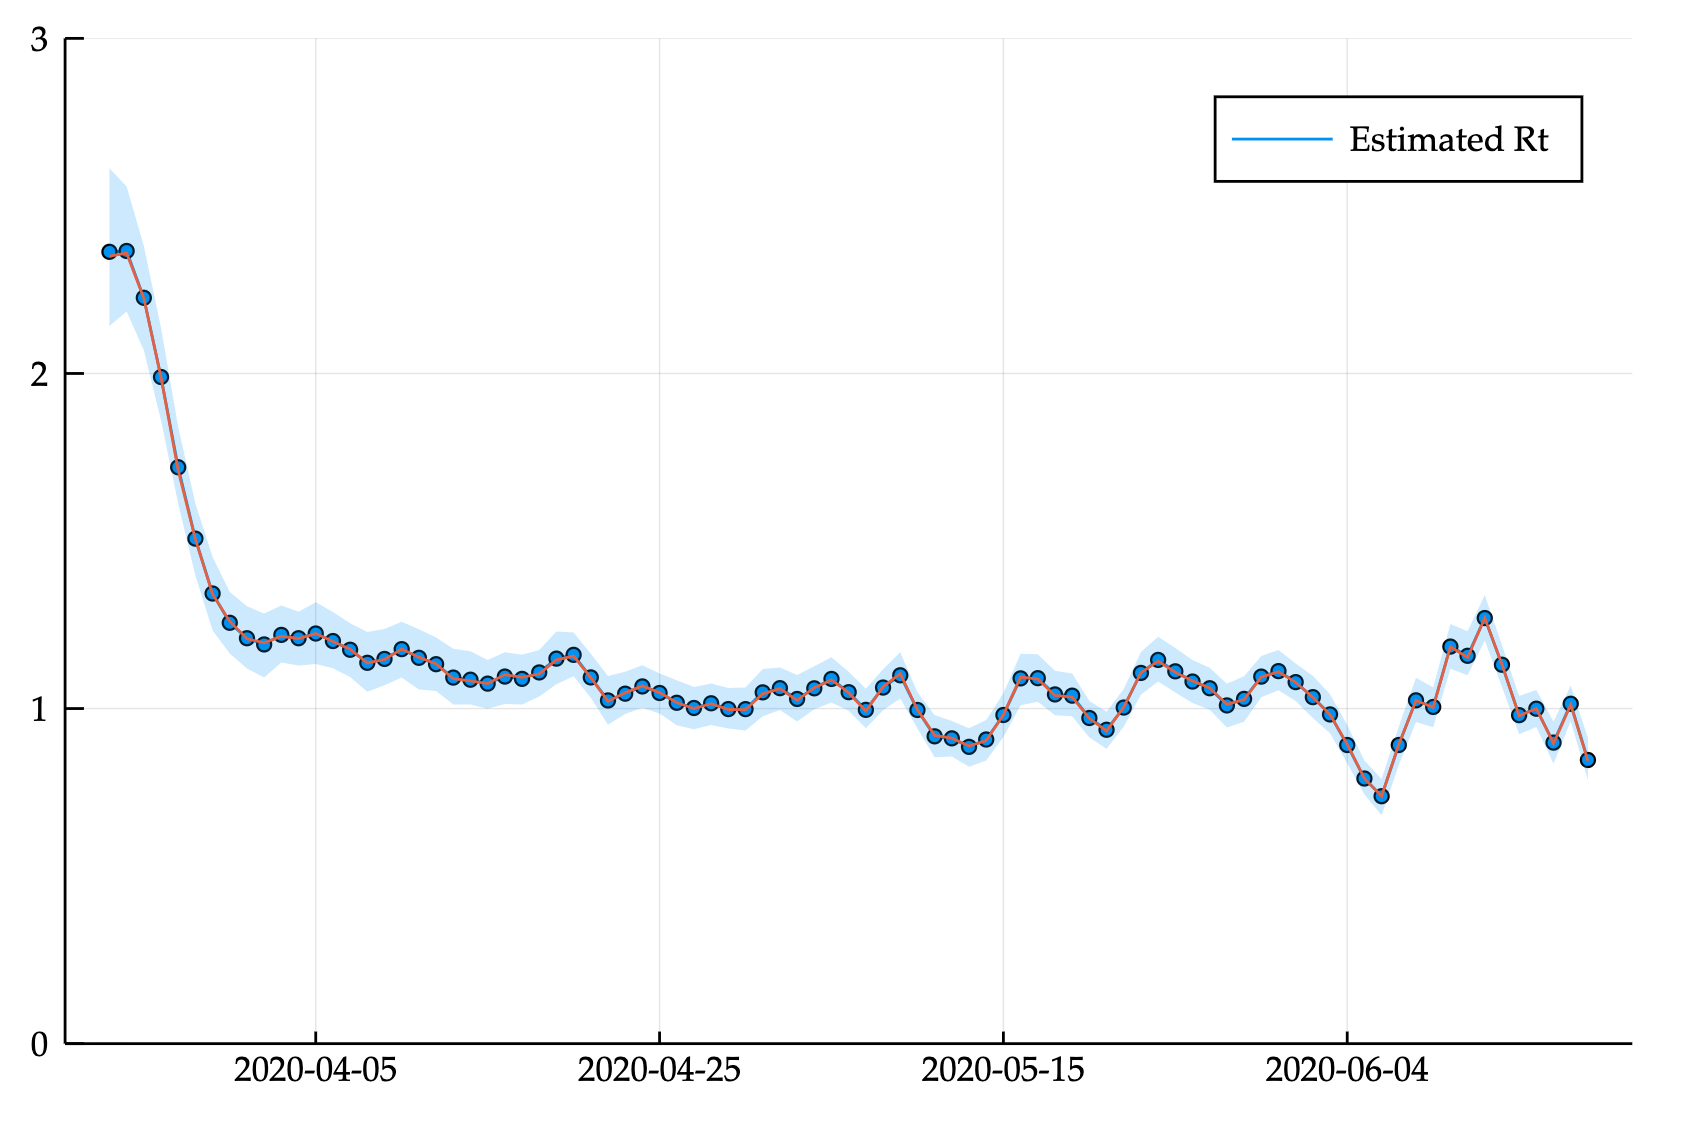

We can see that the error bars are way too tight here to be believable. That's because the quantiles are computed using samples from the posterior *assuming this particular model*, and we have some salient oversimplifications in that model. Nevertheless, these results are pretty close to the ones presented at [rt.live](rt.live), which use a somewhat similar approach but with more complications accounted for.

## Conclusion

The analysis we've presented here includes some simplifying assumptions that we'd want to address as a next step. In addition to the ones mentioned above, you can see in the data that the reports of new cases are being batched by some states (check out South Carolina, for instance). 

### A caveat

As discussed after class with Richard Gaitskell, there are some substantial caveats that are important to bear in mind whenever you use sampling methods to do Bayesian inference:

* The need to choose a prior distribution makes the results of a Bayesian analysis less canonical than they would be for simpler statistical methods (linear regression, for example). Results can be skewed by an investigator's choice of prior.
* Your model might give overconfident results because it's overly simplistic. The error bars you get from doing Bayesian inference are relying on the assumptions you made in building the model. If the real-world underlying probabilistic dynamics are quite different from your model, then the results (even the aspects which quantify uncertainty) can be quite far off the mark.
* It isn't even guaranteed that the sampler is ultimately drawing from the correct distribution. While mathematical theorems typically ensure convergence in the limit as the number of steps tend to infinity, in the real world we have to stop the process at some point, and it isn't always easy to know whether something has gone wrong.

That's all I have for today; thanks again for being here!

---

# Code 

## Simulated data

We begin by loading some packages:

In [18]:
using Turing # probabilistic programming
using Plots, StatsPlots # plotting
using Random # Random number generation 
using UrlDownload # fetching data
using DataFrames, Query # data frames
using Dates # converting date strings

Next we define our model. Note that this is slightly more complicated than the version given in the presentation, but only because we want to be able to use the same model to sample from the prior distribution and perform inference. The issue is that if we supply `missing` for the `cases` array, then the model won't know how long the array is supposed to be. So we make the length its own argument.

In [7]:
@model SIR(n, Rₜ, cases) = begin
    @assert ismissing(cases) || n == length(cases)
    γ⁻¹ = 5
    if ismissing(Rₜ)
        Rₜ = zeros(Real, n)
    end
    Rₜ[1] ~ Uniform(0.5, 3)
    for i in 2:n
        Rₜ[i] ~ truncated(Normal(Rₜ[i-1], 0.1), 0, Inf)
    end
    if ismissing(cases)
        cases = zeros(Integer, n)
    end
    cases[1] ~ DiscreteUniform(10, 100)
    for i in 2:n
        cases[i] ~ Poisson(max(0, Rₜ[i] / γ⁻¹ * sum(cases[max(1, i-γ⁻¹):i-1])))
    end
    Rₜ, cases
end;

Setting the seed for the random number generator so that we get reproducible results:

In [19]:
seed = 37;

Using the model to simulate a run: 

In [22]:
Random.seed!(seed)
Rₜ, cases = SIR(50, missing, missing)();

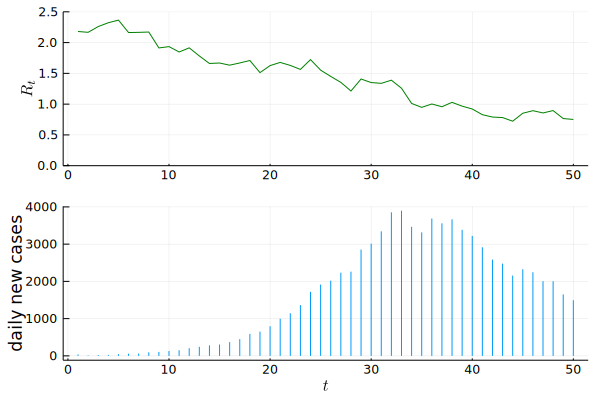

In [23]:
function plot_Rt_and_cases(Rₜ, cases)
    plot(plot(Rₜ, ylabel = "Rt", ylims = (0, 2.5), color = :green), 
         sticks(max.(1, cases), ylabel = "daily new cases", xlabel="t"), 
         layout = (2, 1), legend = false, fontfamily = "Palatino")
end
plot_Rt_and_cases(Rₜ, cases)

Now we supply the values of the simulated `cases` array and infer the conditional distribution of $R_t$ given those values:

In [24]:
chn = sample(SIR(length(cases), missing, cases), NUTS(), 500);

┌ Info: Found initial step size
│   ϵ = 0.025
└ @ Turing.Inference /Users/sswatson/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:15


We can convert the $R_t$ values stored in the chain object to an ordinary array, and then plot the resulting curves. We transpose because by default the Plots package interprets the *columns* of a matrix to be distinct series for plotting.

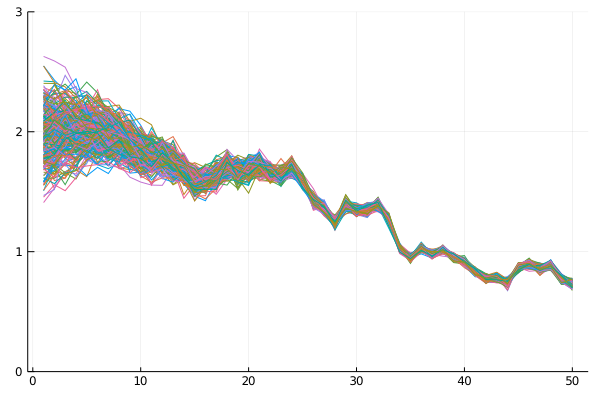

In [25]:
plot(Array(chn[:Rₜ])', leg = false, ylims = (0, 3))

This code takes the chain objects and calculates the mean of the $R_t$ values obtained for each day, as well as the 10% and 90% quantiles: 

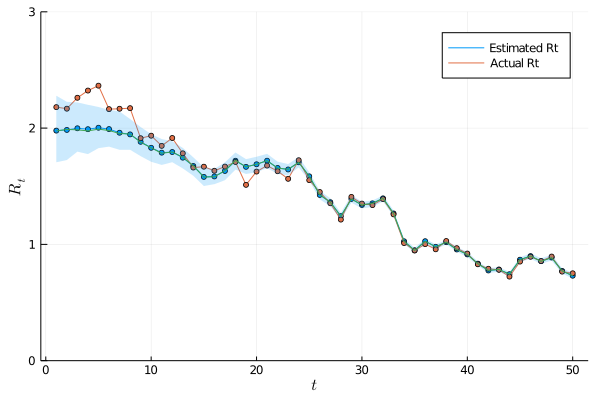

In [26]:
function plot_chain(chn; times = missing, Rₜ = missing)
    plot()
    runs = mean(Array(chn[:Rₜ])', dims = 2)[:]
    if ismissing(times)
        times = 1:length(runs)
    end
    plot!(times, runs, ylims = (0, 3), label = "Estimated Rt")
    scatter!(times, runs, primary = false, ms = 3)
    if !ismissing(Rₜ)
        plot!(times, Rₜ, label = "Actual Rt", ylabel = "Rt", xlabel = "t")
        scatter!(times, Rₜ, primary = false, ms = 3)
    end
    q(chn, r) = [quantile(col, r) for col in eachcol(Array(chn[:Rₜ]))]
    plot!(times, q(chn, 0.1), color = 1, fillrange = q(chn, 0.9),
          fillalpha = 0.2, linewidth = 0, label = false)
    plot!(times, q(chn, 0.5), primary = false, ylims = (0, 3))
end
plot_chain(chn, Rₜ = Rₜ)

### Real data

Load data from the COVID Tracking Project website and process the dates column:

In [14]:
url = "https://covidtracking.com/api/v1/states/daily.csv"
dateparse(s::String) = Date(parse(Int64, s[1:4]), parse(Int64, s[5:6]), parse(Int64, s[7:8]))
dateparse(n::Int) = dateparse(string(n))
df = DataFrame(urldownload(url));
df[!, :date] = dateparse.(df[!, :date]);

┌ Info: Precompiling CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
└ @ Base loading.jl:1260
  likely near /Users/sswatson/.julia/packages/CSV/76SRf/src/utils.jl:70
  likely near /Users/sswatson/.julia/packages/CSV/76SRf/src/write.jl:317


Define which states we want to look at: 

In [28]:
state_string = "MS, SC, CO"

"MS, SC, CO"

Filter the dataset so that we're left only with the specified states: 

In [30]:
states = split(replace(state_string, " " => ""), ",")
subset_df = df |> @filter(_.state ∈ states) |>
                  @orderby(_.state) |>
                  @thenby(_.date) |>
                  DataFrame;

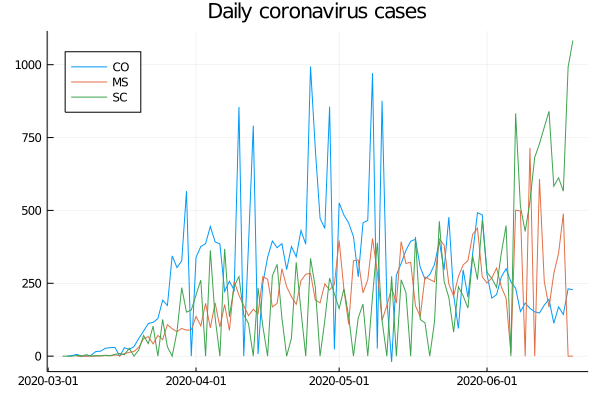

In [31]:
@df subset_df plot(:date, :positiveIncrease, 
                   group = :state, 
                   leg = :topleft, 
                   title = "Daily coronavirus cases")

Set a state to perform the Bayesian inference for:

In [34]:
state = "MS"

"MS"

We're going to smooth the data as a cheap substitute for properly handling the issue that the daily case reports in some states are much more volatile than would be plausible if reporting policies were consistent from day to day. 

In [38]:
lookback = 5
daily_cases = df |> 
    @filter(_.state == state && _.positive ≥ 50) |> 
    @orderby(_.date) |> 
    DataFrame
daily_cases_smoothed = [round(Integer, mean(daily_cases[:, :positiveIncrease][max(1,k-lookback):k])) for k in lookback+1:size(daily_cases,1)];

Finally, we run the sampler on the actual case data from the selected state:

In [39]:
state_chain = sample(SIR(length(daily_cases_smoothed), missing, daily_cases_smoothed), NUTS(), 500);

┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /Users/sswatson/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling:  40%|████████████████▍                        |  ETA: 0:00:29┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/sswatson/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:38


And plot the result:

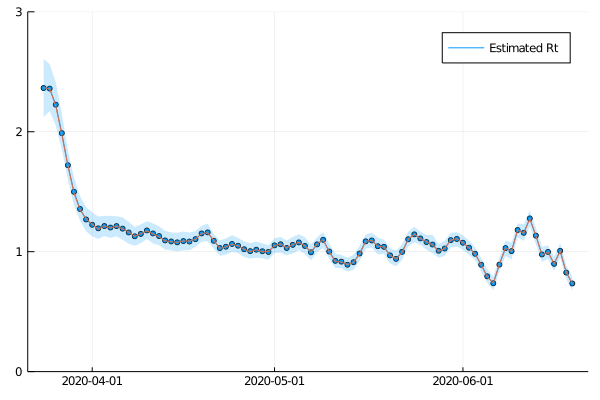

In [40]:
T = size(Array(state_chain[:Rₜ]),2)
plot_chain(state_chain, times = subset_df[end-T+1:end, :date], Rₜ = missing)